In [66]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
import warnings

In [67]:
stop_words = set(stopwords.words('english'))

<h3>Loading Dataset

In [68]:
df = pd.read_csv("Tweeter_tweet2.csv")
df

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
29995,0,1563641594,Sun Apr 19 23:38:14 PDT 2009,NO_QUERY,Nbrayton17,"best weekend ever; Caty Costigans house, Marle..."
29996,0,1563641721,Sun Apr 19 23:38:18 PDT 2009,NO_QUERY,coliwilso,Oh FFS! I've been here all fucking day. Why de...
29997,0,1563641818,Sun Apr 19 23:38:19 PDT 2009,NO_QUERY,redrum231,Leaving britney-just found out jon from new ki...
29998,0,1563649379,Sun Apr 19 23:40:08 PDT 2009,NO_QUERY,ToniaToxic,"@Neomic I havta' go pee, but Im scared to walk..."


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  30000 non-null  int64 
 1   id      30000 non-null  int64 
 2   date    30000 non-null  object
 3   flag    30000 non-null  object
 4   user    30000 non-null  object
 5   text    30000 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.4+ MB


In [70]:
df.isnull().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [71]:
df.drop(['id', 'date', 'flag', 'user', 'target'], axis=1, inplace=True)
df.head()

,text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,is upset that he can't update his Facebook by ...
2,@Kenichan I dived many times for the ball. Man...
3,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all...."


<h3>Data Preprocessing

In [72]:
def data_preprocessing(text):
    #convert all text to lowercase
    text = text.lower()

    #remove any urls
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags = re.MULTILINE)

    #remove punctuations
    text = text.translate(str.maketrans("", "", string.punctuation))

    #remove user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#', "", text)
    text = re.sub(r'[^\w\s]', "", text)
    
    #remove stopwords
    text_tokens = word_tokenize(text)
    filtered_words = [word for word in text_tokens if word not in stop_words]
    
    return " ".join(filtered_words)

In [73]:
df.text = df['text'].apply(data_preprocessing)

In [74]:
df.head()

,text
0,switchfoot thats bummer shoulda got david carr...
1,upset cant update facebook texting might cry r...
2,kenichan dived many times ball managed save 50...
3,whole body feels itchy like fire
4,nationwideclass behaving im mad cant see


In [75]:
df = df.drop_duplicates('text')

In [76]:
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [77]:
warnings.filterwarnings("ignore")

In [78]:
df.text = df['text'].apply(lambda x: stemming(x))

In [79]:
df.head()

,text
0,switchfoot thats bummer shoulda got david carr...
1,upset cant update facebook texting might cry r...
2,kenichan dived many times ball managed save 50...
3,whole body feels itchy like fire
4,nationwideclass behaving im mad cant see


In [80]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [81]:
df['polarity'] = df['text'].apply(polarity) 

In [82]:
df.head(10)

,text,polarity
0,switchfoot thats bummer shoulda got david carr...,0.000000
1,upset cant update facebook texting might cry r...,0.000000
2,kenichan dived many times ball managed save 50...,0.500000
3,whole body feels itchy like fire,0.200000
4,nationwideclass behaving im mad cant see,-0.625000
5,kwesidei whole crew,0.200000
6,need hug,0.000000
7,loltrish hey long time see yes rains bit bit l...,0.341667
8,tatianak nope didnt,0.000000
9,twittera que muera,0.000000


In [83]:
def sentiment(label):
    if label < 0:
        return "Negative"
    elif label == 0:
        return "Neutral"
    elif label > 0:
        return "Positive"

In [84]:
df['sentiment'] = df['polarity'].apply(sentiment)

In [85]:
df.head()

,text,polarity,sentiment
0,switchfoot thats bummer shoulda got david carr...,0.000,Neutral
1,upset cant update facebook texting might cry r...,0.000,Neutral
2,kenichan dived many times ball managed save 50...,0.500,Positive
3,whole body feels itchy like fire,0.200,Positive
4,nationwideclass behaving im mad cant see,-0.625,Negative


<h3>Visualizing Data

<Axes: xlabel='sentiment', ylabel='count'>

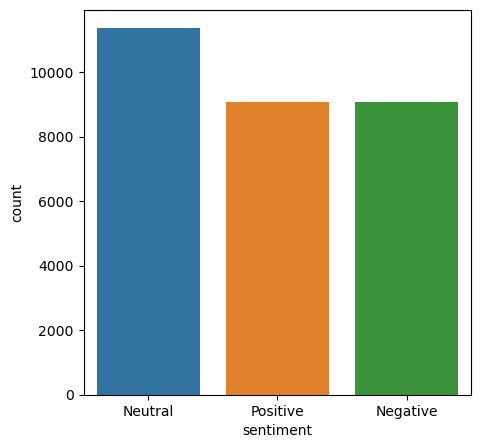

In [86]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='sentiment', data=df)

In [87]:
pos_tweets = df[df.sentiment == 'Positive']
pos_tweets = pos_tweets.sort_values(['polarity'], ascending=False)
pos_tweets

,text,polarity,sentiment
18527,sundae wasnt delicious thought would b ah well...,1.000000e+00,Positive
28162,mussomitchel ever chance coming belgium amp be...,1.000000e+00,Positive
3669,got home going sleep couple hours age conan ho...,1.000000e+00,Positive
9656,warrenandrew miss best,1.000000e+00,Positive
17472,mikeyway used basset hound best dog ever,1.000000e+00,Positive
...,...,...,...
4413,feeling really crappy overdue assignment compl...,1.387779e-17,Positive
20810,alive lonely sarah work today,1.387779e-17,Positive
7963,andreeyuhspooky cept still get early sucks haha,9.251859e-18,Positive
2782,know sucks finding burned tail light stores cl...,6.938894e-18,Positive


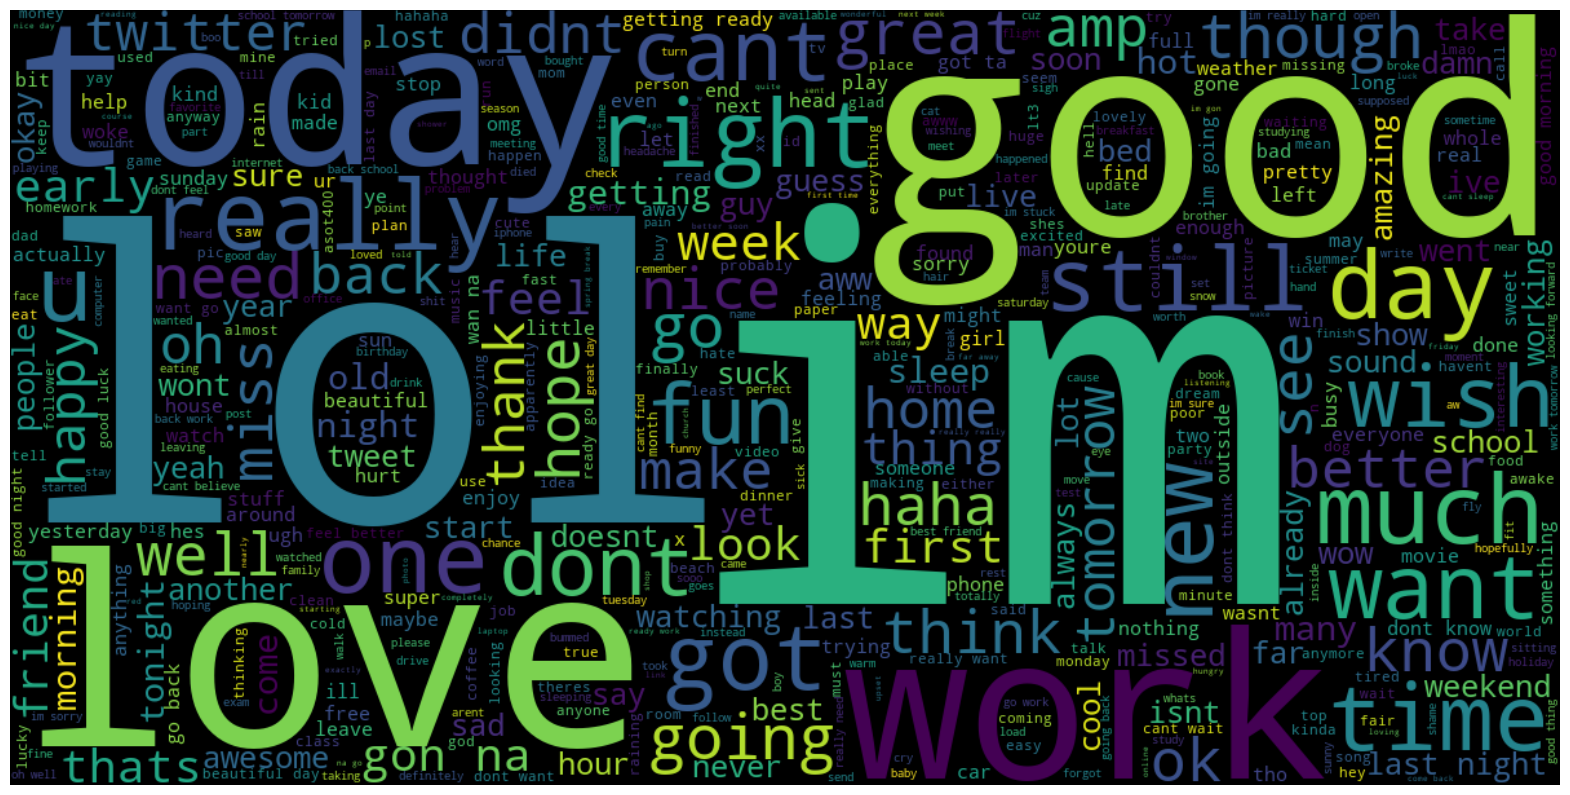

In [88]:
text = ' '.join([word for word in pos_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1200, height=600).generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

In [89]:
neg_tweets = df[df.sentiment == 'Negative']
neg_tweets = neg_tweets.sort_values(['polarity'], ascending=False)
neg_tweets.head(10)

,text,polarity,sentiment
21482,fucken bored watchen band brothers good shit e...,-1.387779e-17,Negative
13339,dbugliari hahaha sorry u feeling good game sti...,-1.387779e-17,Negative
23082,argh bloody english essay booooooo although go...,-1.665335e-17,Negative
6885,alexsegal hey gorgeous going eve im work hella...,-1.850372e-17,Negative
26515,toddklindt good deal ive slacking game time la...,-1.850372e-17,Negative
5594,servermojo love service getting many false pos...,-2.220446e-17,Negative
6869,computer damn slow days fun,-2.775558e-17,Negative
18041,angesbiz slow internet isnt fun anyone,-2.775558e-17,Negative
567,jonathanrknight good knight hun looking forwar...,-2.775558e-17,Negative
10940,im feeling groggy sore little sick good mornin...,-4.464286e-04,Negative


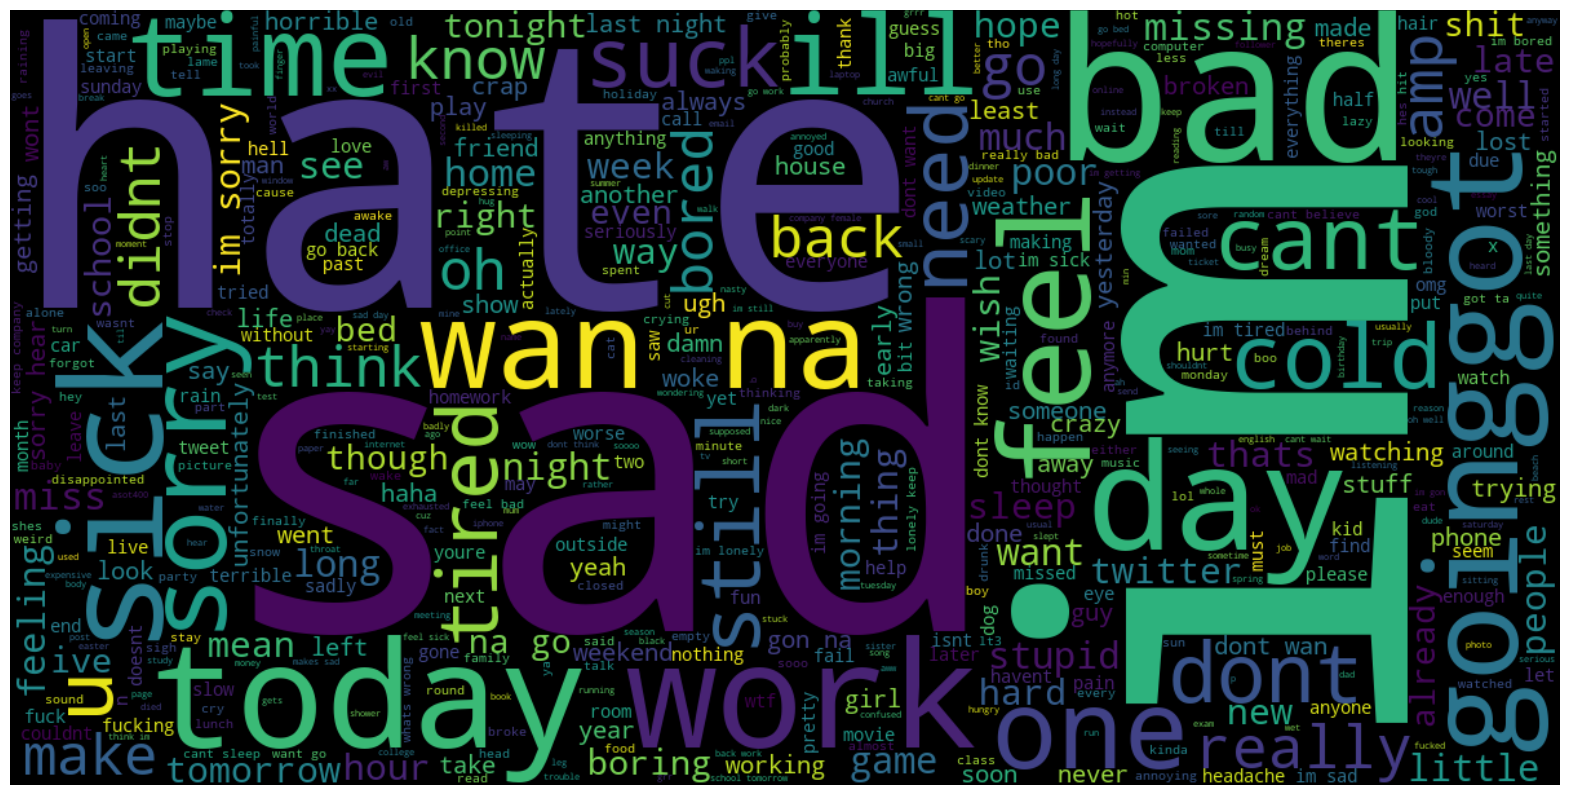

In [90]:
text = ' '.join([word for word in neg_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1200, height=600).generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

In [91]:
ntl_tweets = df[df.sentiment == 'Neutral']
ntl_tweets = ntl_tweets.sort_values(['polarity'], ascending=False)
ntl_tweets.head(10)

,text,polarity,sentiment
0,switchfoot thats bummer shoulda got david carr...,0.0,Neutral
20095,oh dear last day te holidays back school tomor...,0.0,Neutral
20166,5am ive lying bed 4hrs still sleep counted she...,0.0,Neutral
20168,baovo oh didnt answer earlier,0.0,Neutral
20170,fiona2369 u like run dont u wish like u strugg...,0.0,Neutral
20171,back economics hell,0.0,Neutral
20175,mariahcarey goodmerntin work make happen amp s...,0.0,Neutral
20176,mariahcarey im 2 got work 320 im home laying b...,0.0,Neutral
20178,aestivus dont even know,0.0,Neutral
20181,didnt manage get blackberry today maybe next m...,0.0,Neutral


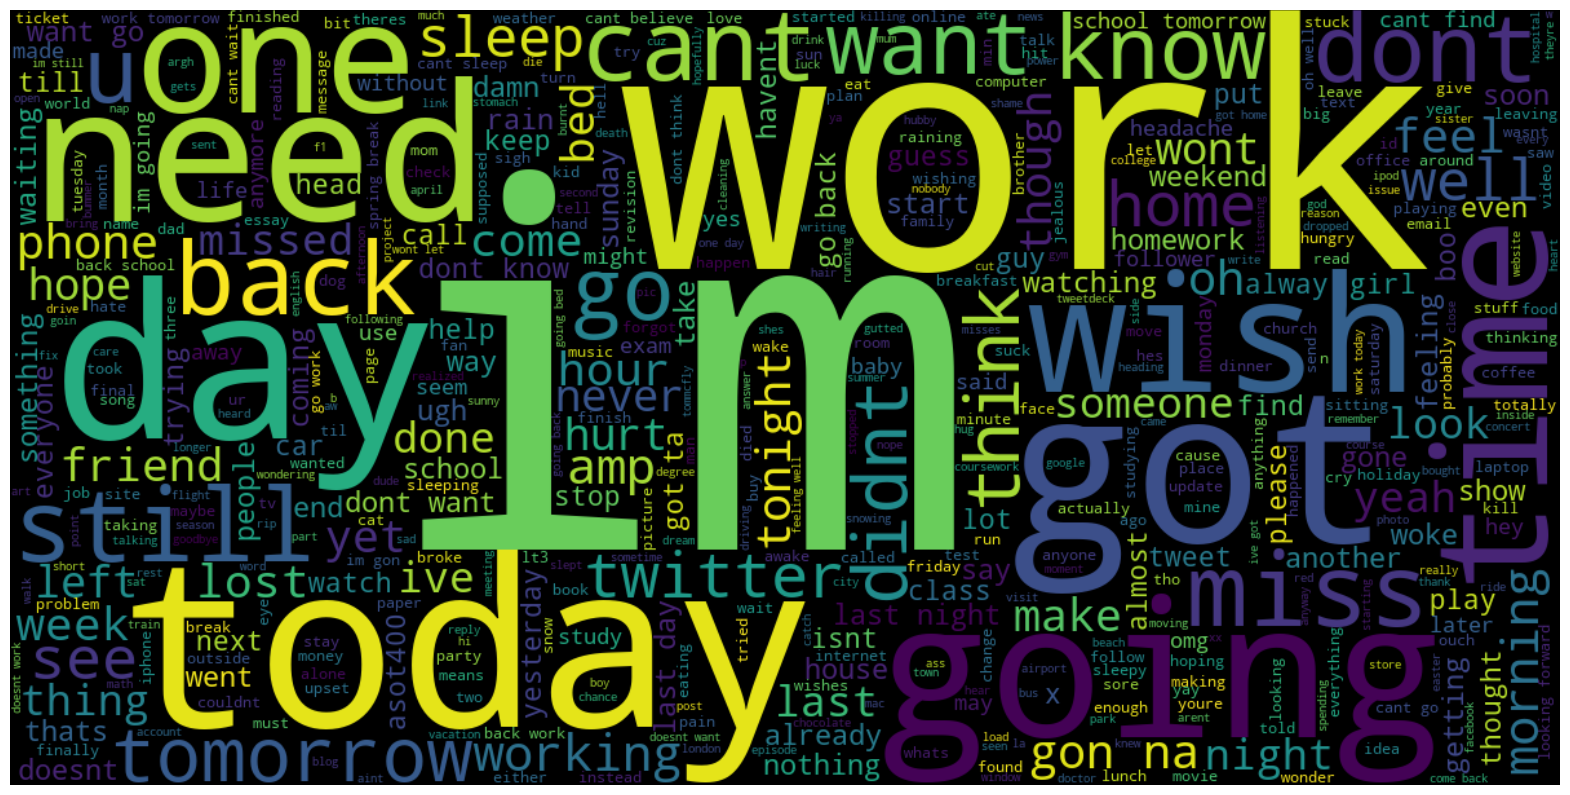

In [92]:
text = ' '.join([word for word in ntl_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1200, height=600).generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

<h3>Fitting to model and checking accuracy

In [93]:
vect = CountVectorizer(ngram_range=(1,2)).fit(df['text'])

In [94]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features:\n {}".format(feature_names[:20]))

Number of features: 190480

First 20 features:
 ['00' '00 hurt' '00 lightning' '00 riley' '00 sad' '0000000000'
 '0000000000 answer' '0010' '0010 even' '001quot' '001quot first' '0105'
 '0105 count' '01500' '02' '02 damn' '03' '03 portland' '033' '033 fee']


In [95]:
X = df['text']
Y = df['sentiment']
X = vect.transform(X)

In [96]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [97]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

LogisticRegression()

In [98]:
logreg_pred = logreg.predict(x_test)

In [99]:
logreg_acc = accuracy_score(logreg_pred, y_test)
print("Test accuracy {:.2f}%".format(logreg_acc*100))

Test accuracy 91.03%


In [100]:
print(confusion_matrix(y_test, logreg_pred))
print("\n")
print(classification_report(y_test, logreg_pred))

[[1572  146  114]
 [  19 2236   24]
 [  65  162 1568]]


              precision    recall  f1-score   support

    Negative       0.95      0.86      0.90      1832
     Neutral       0.88      0.98      0.93      2279
    Positive       0.92      0.87      0.90      1795

    accuracy                           0.91      5906
   macro avg       0.92      0.90      0.91      5906
weighted avg       0.91      0.91      0.91      5906



In [101]:
param_grid1 = {'C':[0.001, 0.01, 0.1, 1, 10]}
grid1 = GridSearchCV(LogisticRegression(), param_grid1)
grid1.fit(x_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [102]:
print("Best parameters: ", grid1.best_params_)

Best parameters:  {'C': 10}


In [103]:
y_pred = grid1.predict(x_test)

In [104]:
logreg_acc = accuracy_score(y_pred, y_test)
print("Test accuracy {:.2f}%".format(logreg_acc*100))

Test accuracy 92.30%


In [105]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[1614  115  103]
 [  17 2239   23]
 [  64  133 1598]]


              precision    recall  f1-score   support

    Negative       0.95      0.88      0.92      1832
     Neutral       0.90      0.98      0.94      2279
    Positive       0.93      0.89      0.91      1795

    accuracy                           0.92      5906
   macro avg       0.93      0.92      0.92      5906
weighted avg       0.92      0.92      0.92      5906



In [106]:
SVCmodel = LinearSVC()
SVCmodel.fit(x_train, y_train)

LinearSVC()

In [107]:
svc_pred = SVCmodel.predict(x_test)

In [108]:
svc_acc = accuracy_score(svc_pred, y_test)
print("Test accuracy {:.2f}%".format(svc_acc*100))

Test accuracy 93.13%


In [109]:
print(confusion_matrix(y_test, svc_pred))
print("\n")
print(classification_report(y_test, svc_pred))

[[1640   93   99]
 [  18 2238   23]
 [  59  114 1622]]


              precision    recall  f1-score   support

    Negative       0.96      0.90      0.92      1832
     Neutral       0.92      0.98      0.95      2279
    Positive       0.93      0.90      0.92      1795

    accuracy                           0.93      5906
   macro avg       0.93      0.93      0.93      5906
weighted avg       0.93      0.93      0.93      5906



In [110]:
param_grid2 = {
    'C': [0.01, 0.1, 1, 10],
    #'kernel': ["linear", "poly", "rbf", "sigmoid"],
    #'degree': [1, 3, 5, 7],
    #'gamma': [0.01, 1]
}
grid2 = GridSearchCV(SVCmodel, param_grid2)
grid2.fit(x_train, y_train)

GridSearchCV(estimator=LinearSVC(), param_grid={'C': [0.01, 0.1, 1, 10]})

In [111]:
print("Best parameters: ", grid2.best_params_)

Best parameters:  {'C': 1}


In [112]:
y_pred = grid2.predict(x_test)

In [113]:
svm_acc = accuracy_score(y_pred, y_test)
print("Test accuracy {:.2f}%".format(svm_acc*100))

Test accuracy 93.13%


In [114]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[1640   93   99]
 [  18 2238   23]
 [  59  114 1622]]


              precision    recall  f1-score   support

    Negative       0.96      0.90      0.92      1832
     Neutral       0.92      0.98      0.95      2279
    Positive       0.93      0.90      0.92      1795

    accuracy                           0.93      5906
   macro avg       0.93      0.93      0.93      5906
weighted avg       0.93      0.93      0.93      5906



In [115]:
naive_model = MultinomialNB()
naive_model.fit(x_train, y_train)

MultinomialNB()

In [116]:
naive_pred = naive_model.predict(x_test)

In [117]:
naive_acc = accuracy_score(naive_pred, y_test)
print("Test accuracy {:.2f}%".format(naive_acc*100))

Test accuracy 81.10%


In [118]:
print(confusion_matrix(y_test, naive_pred))
print("\n")
print(classification_report(y_test, naive_pred))

[[1539   85  208]
 [ 274 1736  269]
 [ 176  104 1515]]


              precision    recall  f1-score   support

    Negative       0.77      0.84      0.81      1832
     Neutral       0.90      0.76      0.83      2279
    Positive       0.76      0.84      0.80      1795

    accuracy                           0.81      5906
   macro avg       0.81      0.82      0.81      5906
weighted avg       0.82      0.81      0.81      5906



In [119]:
param_grid3 = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
}
grid3 = GridSearchCV(MultinomialNB(), param_grid3)
grid3.fit(x_train, y_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]})

In [120]:
print("Best parameters: ", grid3.best_params_)

Best parameters:  {'alpha': 2.0}


In [121]:
y_pred = grid3.predict(x_test)

In [122]:
nb_acc = accuracy_score(y_pred, y_test)
print("Test accuracy {:.2f}%".format(nb_acc*100))

Test accuracy 81.80%


In [123]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[1534   72  226]
 [ 250 1702  327]
 [ 134   66 1595]]


              precision    recall  f1-score   support

    Negative       0.80      0.84      0.82      1832
     Neutral       0.93      0.75      0.83      2279
    Positive       0.74      0.89      0.81      1795

    accuracy                           0.82      5906
   macro avg       0.82      0.82      0.82      5906
weighted avg       0.83      0.82      0.82      5906



In [124]:
tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)

DecisionTreeClassifier()

In [125]:
tree_pred = tree.predict(x_test)

In [126]:
tree_acc = accuracy_score(tree_pred, y_test)
print("Test accuracy {:.2f}%".format(tree_acc*100))

Test accuracy 92.99%


In [127]:
print(confusion_matrix(y_test, tree_pred))
print("\n")
print(classification_report(y_test, tree_pred))

[[1633   35  164]
 [  11 2249   19]
 [ 129   56 1610]]


              precision    recall  f1-score   support

    Negative       0.92      0.89      0.91      1832
     Neutral       0.96      0.99      0.97      2279
    Positive       0.90      0.90      0.90      1795

    accuracy                           0.93      5906
   macro avg       0.93      0.93      0.93      5906
weighted avg       0.93      0.93      0.93      5906



In [128]:
# Input text to be predicted
input_text = "This is a great day! I'm feeling so happy."

# Preprocess the input text
input_text = data_preprocessing(input_text)

# Transform the preprocessed text into numerical features
input_text_features = vect.transform([input_text])

# Make predictions using the trained LinearSVC model
predicted_sentiment = SVCmodel.predict(input_text_features.reshape(1, -1))[0]

# Map the sentiment label to a human-readable form
sentiment_mapping = {
    'Positive': 'Positive sentiment',
    'Neutral': 'Neutral sentiment',
    'Negative': 'Negative sentiment'
}

predicted_sentiment_label = sentiment_mapping[predicted_sentiment]

# Print the predicted sentiment label
print(f"Predicted Sentiment: {predicted_sentiment_label}")


Predicted Sentiment: Positive sentiment


In [130]:
#data={'model':SVCmodel, 'label'}
import pickle
with open('tweet_sentiment_analysis.pkl', 'wb') as f:
    pickle.dump(SVCmodel, f)

In [131]:
with open('count_vectorizer.pkl', 'wb') as vf:
    pickle.dump(CountVectorizer, vf)